# Лабораторная работа №6. "Обучение без учителя. Задача кластеризации"

# ЗАДАНИЕ №1
1. Сгенерировать 3 датасета (make_classification или make_blobs)
2. Провести визуализацию
3. Провести кластеризацию (все методы)
4. Для каждого метода подобрать оптимальные гиперпараметры.
5. Самостоятельно реализовать KMeans. Проверить его работу на датасетах.
6. Каждый метод оценивать 2 внешними и 2 внутренними метриками.

## 1.1 Генерация датасетов

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
from sklearn.datasets import make_blobs, make_classification

x1, y1 = make_blobs(
    n_samples=1000,
    n_features=2
)

x2, y2 = make_classification(
    n_samples=1000,
    n_redundant=0,
    n_features=2
)

x3, y3 = make_classification(
    n_samples=2000,
    n_redundant=0,
    n_features=2
)

## 1.2 Визуализация

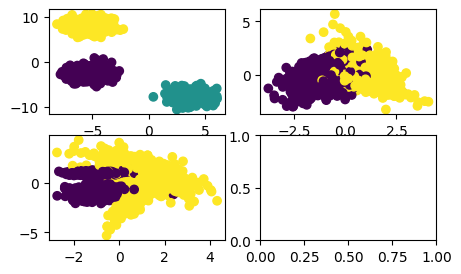

In [112]:
import matplotlib.pyplot as plt

# визуализация полученных графиков
fig, axs = plt.subplots(2,2,figsize=(5,3))
axs[0,0].scatter(x1[:,0], x1[:, 1], c=y1)
axs[0,1].scatter(x2[:,0], x2[:, 1], c=y2)
axs[1,0].scatter(x3[:,0], x3[:, 1], c=y3)

In [113]:
def visualization(x_list: list, y_list: list, a: int = 3, b: int = 2):
    """
    x_list - список иксов: x0,x1..xn
    y_list - список игриков: y0, y1..yn
    a, b - размеры таблицы с графиками
    """
    fig, axs = plt.subplots(a,b,figsize=(10,5))

    for i in range(len(x_list)):
        for j in range(2):
            # для каждого x строится 2 графика: настоящий и помеченный моделью
            axs[i,j].scatter(x_list[i][:,0], x_list[i][:, 1], c=y_list[i*2+j])

## 1.3 Кластеризация

### KMeans

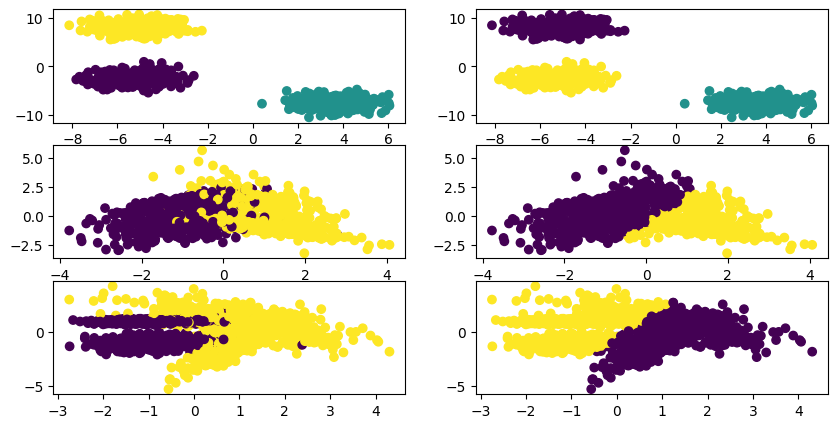

In [114]:
import numpy as np
from sklearn.cluster import KMeans

####################### обучение моделей #######################
kmeans1 = KMeans(n_clusters=np.unique(y1).shape[0], n_init='auto').fit(x1)

kmeans2 = KMeans(n_clusters=np.unique(y2).shape[0], n_init='auto').fit(x2)

kmeans3 = KMeans(n_clusters=np.unique(y3).shape[0], n_init='auto').fit(x3)

####################### визуализация #######################
x_list = [x1,x2,x3]
y_list = [y1,kmeans1.labels_,
          y2,kmeans2.labels_,
          y3,kmeans3.labels_]

visualization(x_list,y_list)

### DB-SCAN

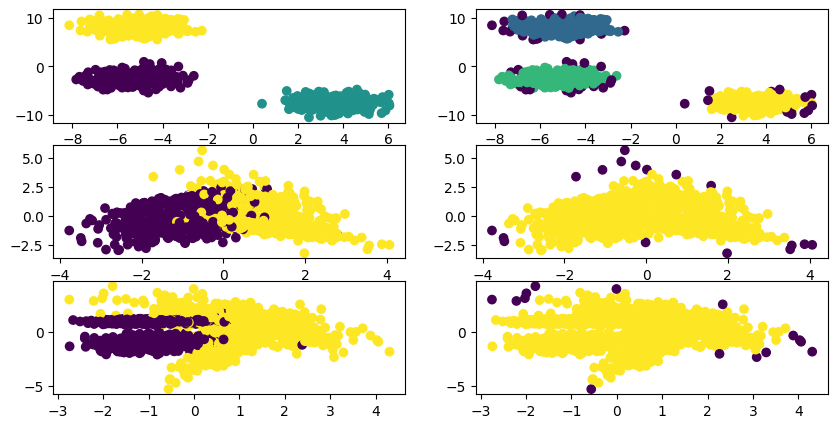

In [115]:
from sklearn.cluster import DBSCAN

####################### обучение моделей #######################
dbscan1 = DBSCAN().fit(x1)

dbscan2 = DBSCAN().fit(x2)

dbscan3 = DBSCAN().fit(x3)

####################### визуализация #######################
y_list = [y1,dbscan1.labels_,
          y2,dbscan2.labels_,
          y3,dbscan3.labels_]
visualization(x_list,y_list)

### GaussianMixture

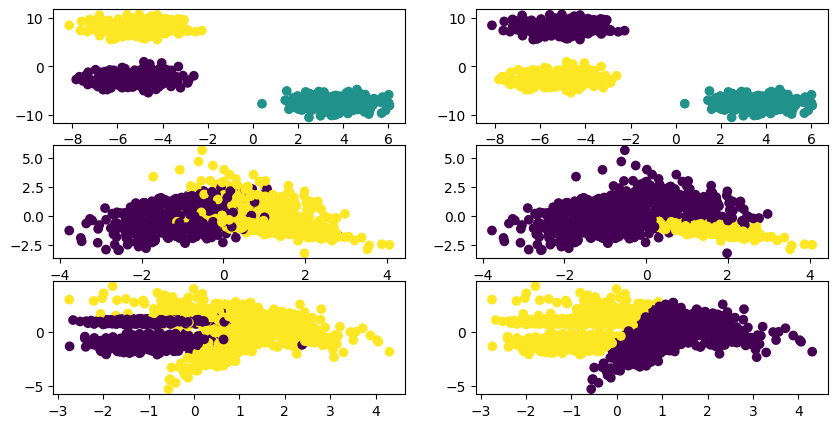

In [116]:
from sklearn.mixture import GaussianMixture

####################### обучение моделей #######################
mixture1 = GaussianMixture(n_components=np.unique(y1).shape[0]).fit(x1)

mixture2 = GaussianMixture(n_components=np.unique(y2).shape[0]).fit(x2)

mixture3 = GaussianMixture(n_components=np.unique(y3).shape[0]).fit(x3)

####################### визуализация #######################
y_list = [y1,mixture1.predict(x1),
          y2,mixture2.predict(x2),
          y3,mixture3.predict(x3)]
visualization(x_list,y_list)

### Иерархическая кластеризация

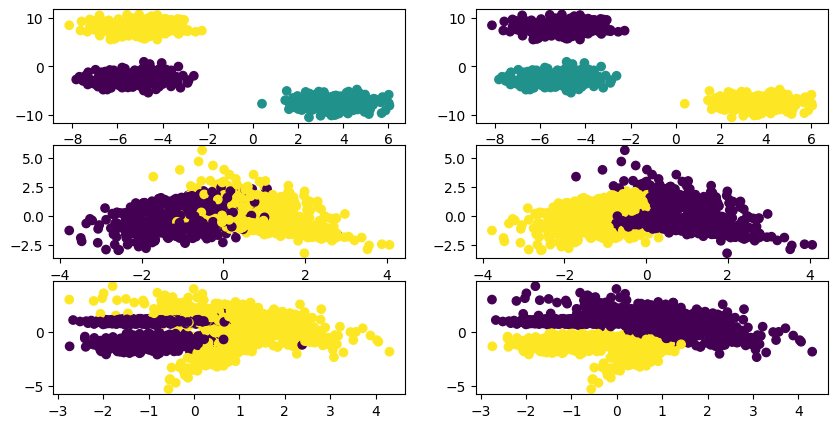

In [117]:
from sklearn.cluster import AgglomerativeClustering

####################### обучение моделей #######################
agg1 = AgglomerativeClustering(n_clusters=np.unique(y1).shape[0]).fit(x1)

agg2 = AgglomerativeClustering(n_clusters=np.unique(y2).shape[0]).fit(x2)

agg3 = AgglomerativeClustering(n_clusters=np.unique(y3).shape[0]).fit(x3)

####################### визуализация #######################
y_list = [y1,agg1.labels_,
          y2,agg2.labels_,
          y3,agg3.labels_]
visualization(x_list,y_list)

## 1.4 Оптимальные гиперпараметры

### KMeans

In [118]:
from sklearn.metrics import silhouette_score
import pandas as pd

def kmeans_best_params(x):
    # массив с инерцией
    WCSS=[]
    # массив коэффициентов силуета
    silhouette_coefficients = []
    for i in range(2,16):
        # обучение модели и добавление данных в датафрейм
        kmeans= KMeans(n_clusters=i, random_state=100)
        kmeans.fit(x)
        # Sum of squared distances of samples to their closest 
        # cluster center, weighted by the sample weights if provided.
        WCSS.append(kmeans.inertia_)
        scores = silhouette_score(x, kmeans.labels_)
        silhouette_coefficients.append(scores)

    return pd.DataFrame({'K':range(2,16), 
                         'WCSS':WCSS, 
                         'silhouette_score':silhouette_coefficients})

In [119]:
# массив с датафреймами со столбцами: K, WCSS, silhouette
optimals = []

# закидываем данные
for x in x_list:
    optimal = kmeans_best_params(x)
    optimals.append(optimal)

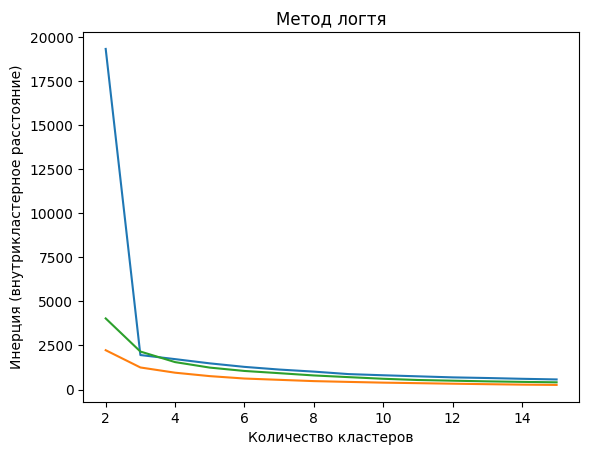

In [120]:
import seaborn as sns

sns.lineplot(x='K', y='WCSS', data=optimals[0])
sns.lineplot(x='K', y='WCSS', data=optimals[1])
sns.lineplot(x='K', y='WCSS', data=optimals[2])
plt.title('Метод логтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция (внутрикластерное расстояние)')
plt.show()

### DB-SCAN

In [121]:
def dbscan_best_params(x, epsilons, min_samples):
    eps_list = []
    min_sample_list = []
    silhouette_coefficients = []
    for eps in epsilons:
        for min_sample in min_samples:
            dbscan= DBSCAN(eps=eps, min_samples=min_sample)
            dbscan.fit(x)
            if len(set(dbscan.labels_)) != 1:
                scores = silhouette_score(x, dbscan.labels_)
                eps_list.append(eps)
                min_sample_list.append(min_sample)
                silhouette_coefficients.append(scores)

    return pd.DataFrame({'eps':eps_list,
                         'min_samples': min_sample_list,
                         'silhouette_score':silhouette_coefficients})

In [122]:
####################### подбор гиперпараметров #######################
for x in x_list:
    optimal = dbscan_best_params(x, epsilons=np.arange(0.1, 3, 0.5),min_samples=np.arange(5,15,3))
    print(optimal.query('silhouette_score >= 0').sort_values('silhouette_score')[:3],'\n')


   eps  min_samples  silhouette_score
5  1.1            5          0.685324
4  0.6           14          0.699022
3  0.6           11          0.739446 

   eps  min_samples  silhouette_score
5  0.6           14          0.459148
2  0.6            5          0.465782
4  0.6           11          0.467374 

   eps  min_samples  silhouette_score
7  0.6           14          0.465640
6  0.6           11          0.472191
5  0.6            8          0.473067 



### GaussianMixture

In [123]:
def mixture_best_params(x, n_components, max_iters):
    n_comp = []
    max_it = []
    silhouette_coefficients = []
    
    for n in n_components:
        for max_iter in max_iters:

            mixture= GaussianMixture(n_components=n, max_iter=max_iter, random_state=100)
            mixture.fit(x)
            scores = silhouette_score(x, mixture.predict(x))

            n_comp.append(n)
            max_it.append(max_iter)
            silhouette_coefficients.append(scores)

    return pd.DataFrame({'n_components':n_comp,
                         'max_iters': max_it,
                         'silhouette_score':silhouette_coefficients})

In [124]:
####################### подбор гиперпараметров #######################
for x in x_list:
    optimal = mixture_best_params(x, n_components=np.arange(2, 11),max_iters=np.arange(100,400,50))
    print(optimal.sort_values('silhouette_score',ignore_index=True)[:3])

   n_components  max_iters  silhouette_score
0             8        250          0.306117
1             8        100          0.306117
2             8        150          0.306117
   n_components  max_iters  silhouette_score
0             6        200           0.27033
1             6        250           0.27033
2             6        300           0.27033
   n_components  max_iters  silhouette_score
0             7        350          0.337467
1             7        300          0.337467
2             7        250          0.337467


### Иерархическая кластеризация

In [125]:
def agg_best_params(x):
    # массив коэффициентов силуета
    silhouette_coefficients = []
    for i in range(2,16):
        # обучение модели и добавление данных в датафрейм
        agg = AgglomerativeClustering(n_clusters=i)
        agg.fit(x)
        scores = silhouette_score(x, agg.labels_)
        silhouette_coefficients.append(scores)

    return pd.DataFrame({'K':range(2,16),  
                         'silhouette_score':silhouette_coefficients})

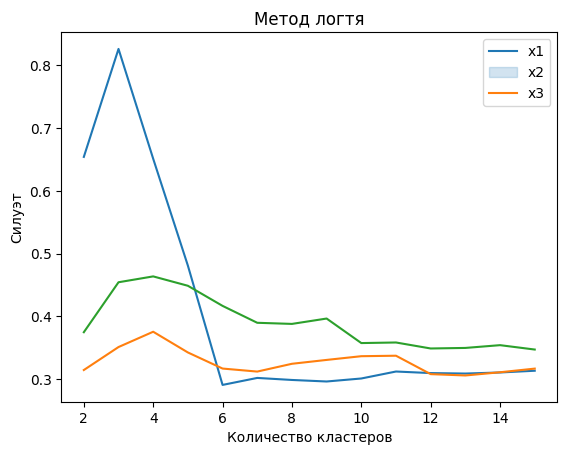

In [126]:
####################### подбор гиперпараметров #######################
data = []
for x in x_list:
    optimal = agg_best_params(x)
    data.append(optimal)

sns.lineplot(x='K', y='silhouette_score', data=data[0])
sns.lineplot(x='K', y='silhouette_score', data=data[1])
sns.lineplot(x='K', y='silhouette_score', data=data[2])
plt.title('Метод логтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')
plt.legend(['x1','x2','x3'])
plt.show()

## 1.6 Оценка моделей

### Внешние метрики

Rand score = (number of agreeing pairs) / (number of pairs)

In [127]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import mutual_info_score

data = [(x1,y1,kmeans1.labels_,'kmeans1'),
        (x2,y2,kmeans2.labels_,'kmeans2'),
        (x3,y3,kmeans3.labels_,'kmeans3'),
        (x1,y1,dbscan1.labels_,'dbscan1'),
        (x2,y2,dbscan2.labels_,'dbscan2'),
        (x3,y3,dbscan3.labels_,'dbscan3'),
        (x1,y1,mixture1.predict(x1),'gaussianMixture1'),
        (x2,y2,mixture2.predict(x2),'gaussianMixture2'),
        (x3,y3,mixture3.predict(x3),'gaussianMixture3'),
        (x1,y1,agg1.labels_,'Иерархическая кластеризация1'),
        (x2,y2,agg2.labels_,'Иерархическая кластеризация2'),
        (x3,y3,agg3.labels_,'Иерархическая кластеризация3')]

show_data = pd.DataFrame(columns=['model','rand_score','homogeneity_score','mutual_info_score'])
for item in data:
    show_data.loc[show_data.shape[0]] = [
        item[3],
        rand_score(item[1],item[2]),
        homogeneity_score(item[1],item[2]),
        mutual_info_score(item[1],item[2])
        ]
show_data

,model,rand_score,homogeneity_score,mutual_info_score
0,kmeans1,1.000000,1.000000,1.098611
1,kmeans2,0.726865,0.379637,0.263132
2,kmeans3,0.807232,0.525046,0.363928
3,dbscan1,0.969313,0.954137,1.048226
4,dbscan2,0.499838,0.003785,0.002623
5,dbscan3,0.499950,0.007596,0.005265
6,gaussianMixture1,1.000000,1.000000,1.098611
7,gaussianMixture2,0.599952,0.241354,0.167286
8,gaussianMixture3,0.822316,0.557317,0.386296
9,Иерархическая кластеризация1,1.000000,1.000000,1.098611


In [128]:
show_data.sort_values('rand_score',ascending=False,ignore_index=True)[:7]

,model,rand_score,homogeneity_score,mutual_info_score
0,kmeans1,1.000000,1.000000,1.098611
1,gaussianMixture1,1.000000,1.000000,1.098611
2,Иерархическая кластеризация1,1.000000,1.000000,1.098611
3,dbscan1,0.969313,0.954137,1.048226
4,gaussianMixture3,0.822316,0.557317,0.386296
5,kmeans3,0.807232,0.525046,0.363928
6,Иерархическая кластеризация2,0.779532,0.480778,0.333234


### Внутренние метрики

- calinski_harabasz_score - Оценка определяется как соотношение суммы дисперсии между кластерами и дисперсии внутри кластера.
- davies_bouldin_score - оценка определяется как средняя мера сходства каждого кластера с его наиболее похожим кластером, где сходство — это отношение расстояний внутри кластера к расстояниям между кластерами. Таким образом, кластеры, расположенные дальше друг от друга и менее рассредоточенные, дадут лучший результат.

In [129]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

show_data = pd.DataFrame(columns=[
    'model','silhouette_score','calinski_harabasz_score','davies_bouldin_score'
])
for item in data:
    show_data.loc[show_data.shape[0]] = [
        item[3],
        silhouette_score(item[0],item[2]),
        calinski_harabasz_score(item[0],item[2]),
        davies_bouldin_score(item[0],item[2])
    ]

In [130]:
show_data.sort_values('silhouette_score',ignore_index=True)[:6]

,model,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,gaussianMixture2,0.301825,409.544326,0.947294
1,Иерархическая кластеризация2,0.314315,483.208538,1.259414
2,kmeans2,0.363381,606.863652,1.074912
3,Иерархическая кластеризация3,0.374596,1154.455798,1.128064
4,kmeans3,0.389468,1225.056218,1.127991
5,gaussianMixture3,0.390419,1222.606312,1.130532


In [131]:
show_data.sort_values('calinski_harabasz_score',ignore_index=True)[:6]

,model,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,dbscan2,0.456387,2.467473,7.874508
1,dbscan3,0.463213,6.425945,4.624514
2,gaussianMixture2,0.301825,409.544326,0.947294
3,Иерархическая кластеризация2,0.314315,483.208538,1.259414
4,kmeans2,0.363381,606.863652,1.074912
5,Иерархическая кластеризация3,0.374596,1154.455798,1.128064


In [132]:
show_data.sort_values('davies_bouldin_score',ignore_index=True)[:6]

,model,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,kmeans1,0.826204,15179.639850,0.238640
1,gaussianMixture1,0.826204,15179.639850,0.238640
2,Иерархическая кластеризация1,0.826204,15179.639850,0.238640
3,gaussianMixture2,0.301825,409.544326,0.947294
4,kmeans2,0.363381,606.863652,1.074912
5,kmeans3,0.389468,1225.056218,1.127991


## 1.5 Своя реализация KMeans

В ноутбуке Lab6_kMeans.ipynb

# ЗАДАНИЕ №2.
1. На основе датасета для задачи классификации построить модель кластеризации, используя три метода: k-means; иерархическая кластеризация; DBSCAN.
2. Произвести визуализацию построенных моделей.
3. Выполнить оценку качества полученных моделей кластеризации. Сравнить полученные результаты.

In [133]:
import pandas as pd
df = pd.read_csv('../../../Datasets/Lab4_DataSet4_Preprocessed.csv').drop('id',axis=1)
df = df.drop_duplicates()
df.head()

,Airline_0,Airline_1,Airline_2,Airline_3,Airline_4,Flight,AirportFrom_0,AirportFrom_1,AirportFrom_2,AirportFrom_3,...,AirportTo_3,AirportTo_4,AirportTo_5,AirportTo_6,AirportTo_7,AirportTo_8,DayOfWeek,Time,Length,Delay
0,0,0,0,0,1,3036,0,0,0,0,...,0,0,0,0,0,1,4,1195,131,0
1,0,0,0,1,0,315,0,0,0,0,...,0,0,0,0,1,0,7,707,145,0
2,0,0,0,1,1,6673,0,0,0,0,...,0,0,0,0,1,1,5,499,42,1
3,0,0,1,0,0,3668,0,0,0,0,...,0,0,0,0,1,0,2,810,70,1
4,0,0,1,0,1,623,0,0,0,0,...,0,0,0,1,0,0,5,985,143,0


In [134]:
def reduce_mem_usage(df:pd.DataFrame):
  import numpy as np
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
    col_type = df[col].dtypes
    if str(col_type)[:5] == 'float':
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min>np.finfo('f2').min and c_max < np.finfo('f2').max:
        df[col]=df[col].astype(np.float16)
      elif c_min>np.finfo('f4').min and c_max < np.finfo('f4').max:
        df[col]=df[col].astype(np.float32)
      else:
        df[col]=df[col].astype(np.float64)
    elif str(col_type)[:3] == 'int':
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min>np.iinfo('i1').min and c_max < np.iinfo('i1').max:
        df[col]=df[col].astype(np.int8)
      elif c_min>np.iinfo('i2').min and c_max < np.iinfo('i2').max:
        df[col]=df[col].astype(np.int16)
      elif c_min>np.iinfo('i4').min and c_max < np.iinfo('i4').max:
        df[col]=df[col].astype(np.int32)
      elif c_min>np.iinfo('i8').min and c_max < np.iinfo('i8').max:
        df[col]=df[col].astype(np.int64)
    elif col == 'timestamp':
      df[col]=pd.to_datetime(df[col])
    elif str(col_type)[:8] != 'datetime':
      df[col]=df[col].astype('category')
  end_mem=df.memory_usage().sum() /1024**2
  print('Потребление памяти на', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
  return df

In [135]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df[['Flight','DayOfWeek','Time','Length']] = scaler.fit_transform(df[['Flight','DayOfWeek','Time','Length']])

df = reduce_mem_usage(df)

Потребление памяти на 46.69 Мб (минус 82.8 %)


In [136]:
from sklearn.model_selection import train_test_split

X = df.drop('Delay', axis=1)
Y = df['Delay']

# x_tr, x_test, y_tr, y_test = train_test_split(X,Y,test_size=0.2)

In [137]:
from sklearn.metrics import accuracy_score
show_data = pd.DataFrame(columns=['model','rand_score','accuracy'])

In [ ]:
kmeans = KMeans(n_clusters=2).fit(X)
show_data.loc[show_data.shape[0]] = ['kmeans',
                                      rand_score(Y,kmeans.labels_),
                                      accuracy_score(Y,kmeans.labels_)]



dbscan = DBSCAN().fit(X)
show_data.loc[show_data.shape[0]] = ['DBSCAN',
                                      rand_score(Y,dbscan.labels_),
                                      accuracy_score(Y,dbscan.labels_)]
show_data

In [147]:
x_tr, x_test, y_tr, y_test = train_test_split(X,Y,test_size=0.8)
agg = AgglomerativeClustering(n_clusters=2).fit(x_tr)
show_data.loc[show_data.shape[0]] = ['иерархическая',
                                      rand_score(y_tr,agg.labels_),
                                      accuracy_score(y_tr,agg.labels_)]
show_data

,model,rand_score,accuracy
0,kmeans,0.506107,0.444733
1,kmeans,0.506107,0.555267
2,DBSCAN,0.449325,0.000098
3,иерархическая,0.542087,0.645078


# ЗАДАНИЕ №3*.
Реализовать алгоритма DBSCAN и с его помощью провести кластеризацию всех датасетов Лаб_работы №6.

Не сделано :)